In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)



Toggle code

# Plot regional maps with mean current ellipses on top


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


import iris
import iris.plot as iplt
import iris.quickplot as qplt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


import palettable
from palettable import colorbrewer
from palettable.cmocean.sequential import Ice_12 as ocean_blue
from palettable.cmocean.sequential import Gray_12 as ocean_gray

plt.style.use('dark_background')
%matplotlib inline

#plt.rcParams.update({'font.size': 14})

## 1. Load data

### Load location of EEL stations

In [3]:
pathdir = '../data/raw/csv_ctdgrid'

file3 = pathdir+'/'+'EELCTDandLADCP_refpos.csv'
dfloc = pd.read_csv(file3,sep=',', index_col=None, 
                     header=0)
# Make sure the station name are sorted by their distance along the section
sdfloc = dfloc.sort_values('Refdist', ascending=True)
sdfloc

,Staname,Refdist,LonSta,LatSta,DepthSta
68,IB23S,0.000000,-20.215,63.317,120
67,IB22S,13.442044,-20.067,63.216,670
66,IB21S,25.375111,-19.916,63.133,1030
65,IB20S,55.616831,-19.551,62.917,1400
64,IB19S,84.025700,-19.668,62.667,1670
...,...,...,...,...,...
4,5G,1277.489387,-6.600,56.733,80
3,4G,1286.632474,-6.450,56.733,115
2,3G,1292.405649,-6.367,56.708,70
1,2G,1298.235343,-6.283,56.683,30


<br><br>
### Load LADCP Current data into a dataframe

In [4]:
file4 = pathdir+'/'+'EEL_LADCP_3Dfield.csv'
dflad = pd.read_csv(file4,sep=',', index_col=None, 
                     header=0)
dflad=dflad.round({'Refdist': 0, 'LADCP_U': 3, 'LADCP_V': 3})
dflad

,CruiseID,Year,Staname,Refdist,Depth,LADCP_U,LADCP_V
0,d22396,1996,13G,1191.0,25,-0.227,0.019
1,d22396,1996,13G,1191.0,35,-0.230,0.044
2,d22396,1996,13G,1191.0,45,-0.236,0.049
3,d22396,1996,13G,1191.0,55,-0.251,0.052
4,d22396,1996,13G,1191.0,65,-0.283,0.066
...,...,...,...,...,...,...,...
76029,dy078,2017,IB23S,0.0,65,0.026,0.078
76030,dy078,2017,IB23S,0.0,75,0.045,0.146
76031,dy078,2017,IB23S,0.0,85,0.036,0.166
76032,dy078,2017,IB23S,0.0,95,0.026,0.180


In [5]:
# Calculate depth average current using a pivot table
df_U = dflad.pivot_table(values='LADCP_U', index="Year", columns="Staname").round(3)
df_V = dflad.pivot_table(values='LADCP_V', index="Year", columns="Staname").round(3)
df_V

Staname,10G,13G,14G,15G,8G,9G,A,B,C,D,...,L,M,N,O,P,Q,Q1,R,S,T
Year,,,,,,,,,,,,,,,,,,,,,
1996,NaN,0.055,0.080,0.116,NaN,NaN,-0.030,0.001,0.086,0.017,...,-0.105,-0.059,0.145,-0.013,0.083,0.222,0.168,0.118,0.120,0.118
1997,NaN,NaN,NaN,NaN,NaN,NaN,0.024,NaN,NaN,0.009,...,NaN,-0.053,-0.023,0.021,-0.001,0.106,0.047,0.199,NaN,-0.269
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.187,...,NaN,-0.032,-0.044,-0.058,0.038,0.303,0.250,-0.131,NaN,NaN
1999,NaN,NaN,NaN,NaN,NaN,NaN,-0.035,-0.074,0.191,0.094,...,0.053,-0.187,-0.039,0.027,0.117,0.169,0.155,NaN,NaN,NaN
2000,-0.116,NaN,NaN,-0.056,NaN,-0.101,NaN,NaN,NaN,NaN,...,-0.016,0.003,-0.120,0.066,0.141,0.096,0.230,-0.126,-0.141,-0.004
2005,NaN,-0.031,-0.011,NaN,0.102,-0.017,0.077,-0.114,-0.027,-0.034,...,0.059,0.071,-0.087,-0.031,-0.005,0.253,0.135,0.275,NaN,0.014
2006,NaN,NaN,NaN,-0.068,NaN,NaN,0.027,0.139,-0.161,-0.019,...,-0.090,-0.049,0.042,0.015,0.002,0.148,0.123,-0.048,-0.190,0.125
2009,NaN,NaN,NaN,-0.189,NaN,NaN,-0.180,-0.048,0.052,-0.367,...,-0.123,-0.084,-0.039,-0.080,0.022,0.234,0.135,-0.149,-0.310,-0.114
2010,0.007,0.203,NaN,-0.075,NaN,0.172,0.012,0.146,0.192,-0.108,...,-0.286,-0.143,0.118,0.074,0.037,0.097,0.085,-0.093,-0.130,-0.041


In [6]:
# Merge Statistics for U and V LADCP components into a dictionary after transposing the dataframe so the stats are columns
stats = {'U':df_U.describe().T.round(3),
         'V':df_V.describe().T.round(3)}

stats['V']=stats['V'].add_suffix('_V')
stats['U']=stats['U'].add_suffix('_U')
# 
stalist = ['IB21S','IB15','IB4C','E','13G']
stats['U'].loc[stalist,:]
# # To convert the mean U velocity component into a numpy array we just need to do:
# np.array(stats['U']['mean'])


,count_U,mean_U,std_U,min_U,25%_U,50%_U,75%_U,max_U
Staname,,,,,,,,
IB21S,9.0,-0.000,0.069,-0.135,-0.046,0.033,0.056,0.060
IB15,12.0,-0.060,0.100,-0.290,-0.070,-0.024,-0.004,0.038
IB4C,5.0,0.020,0.058,-0.042,-0.030,0.012,0.075,0.085
E,13.0,-0.026,0.072,-0.146,-0.077,-0.028,0.033,0.096
13G,5.0,-0.111,0.110,-0.256,-0.154,-0.132,-0.047,0.035


\
Create a short function to sort the row of the dataframe according to the reference distance of each station. Add also additional metadata (Lat, Lon, Depth)

In [7]:
def sortEELPV(dftosort, refdf=sdfloc):
    """ 
    Function to sort a dataframe where the rows correspond to Extend Ellet Line station name.
    The rows are sorted according to another dataframe containing the reference distance along 
    the EEL section associated to every station. Additional metadata corresponding to the reference station (lat, lon, depth)
    are also merged into the new dataframe.

    """
    dfnew=pd.merge(refdf,
                   dftosort,
                   how='left',
                   on='Staname').round(3)
    dfnew = dfnew.set_index('Staname',drop=True)      
    return dfnew


# Sort the rows according to location of the station along the section.
# We use the reference dataframe sdfloc and merge additional metadata from sdfloc (lat, lon) into the new dataframe
stats['U'] = sortEELPV(stats['U'], refdf=sdfloc)
stats['V'] = sortEELPV(stats['V'], refdf=sdfloc)

In [8]:
print(f"Depth Average U component for stations {stalist} :\n{stats['U'].loc[stalist,:]}\n\n")
print(f"Depth Average V component:\n{stats['V'].loc[stalist,:]}")

Depth Average U component for stations ['IB21S', 'IB15', 'IB4C', 'E', '13G'] :
          Refdist  LonSta  LatSta  DepthSta  count_U  mean_U  std_U  min_U  \
Staname                                                                      
IB21S      25.375 -19.916  63.133      1030      9.0  -0.000  0.069 -0.135   
IB15      243.437 -20.000  61.250      2380     12.0  -0.060  0.100 -0.290   
IB4C      612.552 -16.750  58.757      1140      5.0   0.020  0.058 -0.042   
E         897.846 -12.633  57.533      1650     13.0  -0.026  0.072 -0.146   
13G      1191.420  -8.000  56.783       110      5.0  -0.111  0.110 -0.256   

         25%_U  50%_U  75%_U  max_U  
Staname                              
IB21S   -0.046  0.033  0.056  0.060  
IB15    -0.070 -0.024 -0.004  0.038  
IB4C    -0.030  0.012  0.075  0.085  
E       -0.077 -0.028  0.033  0.096  
13G     -0.154 -0.132 -0.047  0.035  


Depth Average V component:
          Refdist  LonSta  LatSta  DepthSta  count_V  mean_V  std_V  min_V  \
S

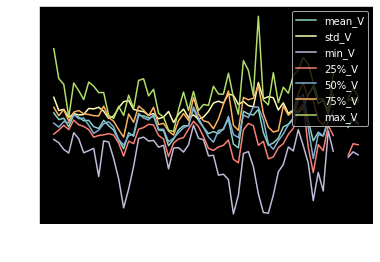

In [9]:
stats['V'].iloc[:,5:].plot()

\
#### Merge dataframes stats['U'] and stats['V'] on the station name variable 

In [10]:
# Drop duplicate columns in stats['V']
stats['V'] = stats['V'].drop(columns=['Refdist', 'LonSta', 'LatSta', 'DepthSta'])
    
DAClad = pd.merge(stats['U'],
                stats['V'],
                how='outer',
                on='Staname')

DAClad

,Refdist,LonSta,LatSta,DepthSta,count_U,mean_U,std_U,min_U,25%_U,50%_U,75%_U,max_U,count_V,mean_V,std_V,min_V,25%_V,50%_V,75%_V,max_V
Staname,,,,,,,,,,,,,,,,,,,,
IB23S,0.000,-20.215,63.317,120,8.0,0.023,0.102,-0.147,-0.024,0.062,0.083,0.135,8.0,0.066,0.133,-0.048,-0.025,0.022,0.090,0.341
IB22S,13.442,-20.067,63.216,670,11.0,-0.052,0.049,-0.119,-0.074,-0.064,-0.030,0.048,11.0,0.037,0.076,-0.062,-0.008,0.005,0.054,0.213
IB21S,25.375,-19.916,63.133,1030,9.0,-0.000,0.069,-0.135,-0.046,0.033,0.056,0.060,9.0,0.043,0.081,-0.091,0.013,0.029,0.080,0.188
IB20S,55.617,-19.551,62.917,1400,9.0,-0.045,0.072,-0.136,-0.078,-0.070,-0.003,0.091,9.0,0.006,0.047,-0.106,-0.006,0.023,0.031,0.048
IB19S,84.026,-19.668,62.667,1670,9.0,-0.073,0.072,-0.179,-0.106,-0.092,-0.026,0.055,9.0,0.058,0.063,-0.019,0.035,0.059,0.069,0.194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5G,1277.489,-6.600,56.733,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4G,1286.632,-6.450,56.733,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3G,1292.406,-6.367,56.708,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br><br>
## 2. Quiver plots of mean current at each EEL station


#### Plot a topography map using the etopo1 data from the NOAA opendap server. With iris we can slice the data before downloading it. Finally we will "print" our cube to check the metadata.

In [11]:
# Definition variables for maps
central_lon, central_lat = -10, 45
extent_extract = [-30, 10, 50, 70]
extent_map = [-26, 0, 51, 66]

In [12]:
def get_cube(url):
    coord_values = {'latitude':lambda cell: extent_extract[2] <= cell <= extent_extract[3],
                    'longitude': lambda cell: extent_extract[0] <= cell <= extent_extract[1]}
    constraint = iris.Constraint(coord_values=coord_values)
    bathy = iris.load_cube(url, constraint)
    return bathy


# # High Resolution bathy
# bathy = get_cube('http://thredds.aoos.org/thredds/dodsC/GEBCO2014_NORTHERN_HEM.nc') 

# Low Resolution bathy
bathy = get_cube('http://navigator.oceansdata.ca:8080/thredds/dodsC/Misc/ETOPO1_Bed_g_gmt4.grd')

bathy = iris.util.squeeze(bathy)



print(bathy)

z / (1)                             (latitude: 1200; longitude: 2400)
     Dimension coordinates:
          latitude                           x                -
          longitude                          -                x
     Attributes:
          Conventions: COARDS/CF-1.0
          GMT_version: 4.4.0
          actual_range: [-10898.   8271.]
          node_offset: 0
          title: ETOPO1_Bed_g_gmt4.grd


<br><br>
### Define Plotting function

\
Define specific function to plot map

In [13]:
# Define a function to plot the background map
def plot_bathy_ENA(fig=False,ax=False,limits='default',gridlines=True,colorbar=True):
    """ Function to plot the map of the Eastern North Atlantic with the associated bathymetry

    plot_bathy_ENA(fig=False,ax=False,limits='default',gridlines=True,colorbar=True)
    
    Returns:
    (fig, ax, cplot): Figure, axes and contourf objects generated by plt.subplots

    """
    
    land = colorbrewer.get_map('Accent', 'qualitative', 8)
    ocean = ocean_gray # grey colormap for bathymetry 
    colors = np.array(ocean.mpl_colors[-6:]) # Blue colormap

    levels = [-3000, -2000, -1250, -1000, -650, -200, 0]

    #titlefig = 'Map Eastern North Atlantic'
    if not fig:
        fig, ax = plt.subplots(figsize=(12, 12),
                               subplot_kw=dict(projection=ccrs.Mercator(central_lon, central_lat)))
    else:
        plt.axes(ax)
    
    cplot = iris.plot.contourf(bathy, levels, colors=colors, extend='both')
    cplot.cmap.set_under(ocean.mpl_colors[-7])
    cplot.cmap.set_over(land.mpl_colors[-1])

    # Set the colormap limits
    plt.clim([np.min(levels),np.max(levels)])
    
    if colorbar:
        cbar = plt.colorbar(cplot, ax=ax, orientation="vertical", pad=.05, aspect=40)  
        cbar.ax.set_ylabel('Depth (m)')
        
    if limits=='default':
        ax.set_extent([-28.1, 0.1, 51, 66])
    else:
        ax.set_extent(limits)       
        
    ax.coastlines('10m', color='k')

    if (limits=='default') & gridlines:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), ylocs=np.arange(52,68,2),
                          draw_labels=True, linewidth=1, color='gray', alpha=0.8, linestyle='-.')

        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    
    return (fig, ax, cplot)

\
Define specific function to plot specific gridlines on a map

In [14]:
# Define a function to plot grid axis on map
def plot_gridlines(ax,xtick,ytick):
    """ Function to plot gridline on a map generated by cartopy (on a PlateCarree projection)

    plot_gridlines(ax,xtick,ytick)
    
    Returns:
    gl: gridline object

    """
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                       linewidth=1, color='gray', alpha=0.8, linestyle='-.')
    gl.ylocator = mticker.FixedLocator(ytick)
    gl.xlocator = mticker.FixedLocator(xtick)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
 
    
    return gl

In [15]:
plot_bathy_ENA?

Signature:
plot_bathy_ENA(
    fig=False,
    ax=False,
    limits='default',
    gridlines=True,
    colorbar=True,
)
Docstring:
Function to plot the map of the Eastern North Atlantic with the associated bathymetry

plot_bathy_ENA(fig=False,ax=False,limits='default',gridlines=True,colorbar=True)

Returns:
(fig, ax, cplot): Figure, axes and contourf objects generated by plt.subplots
File:      ~/Dropbox/Work/Python/Repos_perso/analysis_eel_data/notebooks/<ipython-input-13-a379b3ce8c56>
Type:      function


\
Test 

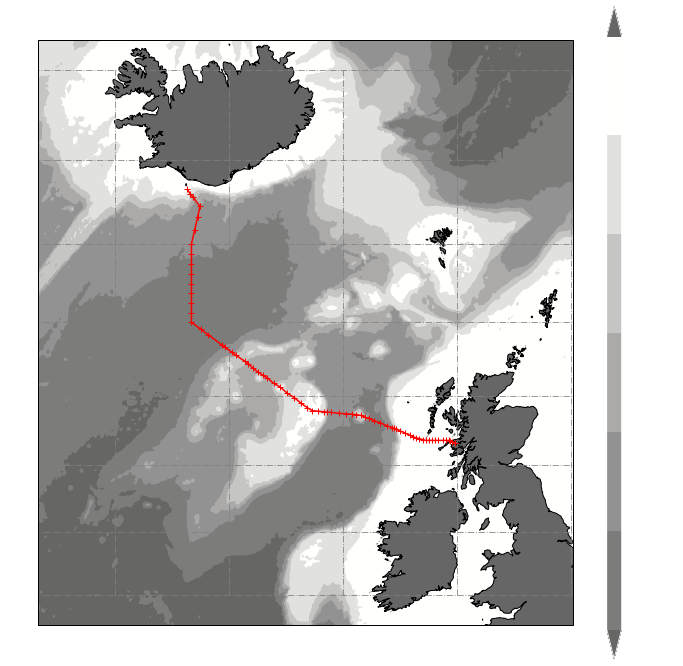

In [16]:
# plot map with EEL stations
(fig,ax,cplot)=plot_bathy_ENA()    

ax.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree())


\\
### Plot Mean depth average current at each station

In [17]:
# Get the index name of the station east of station R
ibad=DAClad.loc['R':,:].index.values
# Drop the associated row from dataframe
DAClad=DAClad.drop(ibad)

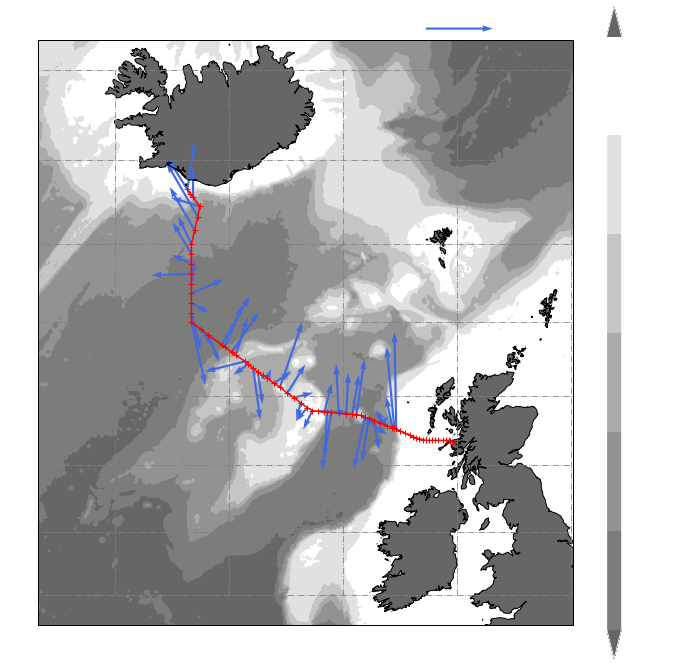

In [18]:
lon = np.array(DAClad['LonSta'])
lat = np.array(DAClad['LatSta'])
U = np.array(DAClad['mean_U'])
V = np.array(DAClad['mean_V'])

Qv = ax.quiver(lon, lat, U,  V, transform=ccrs.PlateCarree(),
              scale=0.8,
              color='royalblue',
              width=0.004)
    
qk = ax.quiverkey(Qv,0.85, 1.02, 0.1,'10 cm/s', labelpos='E')

fig

##### Same map but with the plotted arrows corresponding to the depth average current\*water depth to represent a transport per km

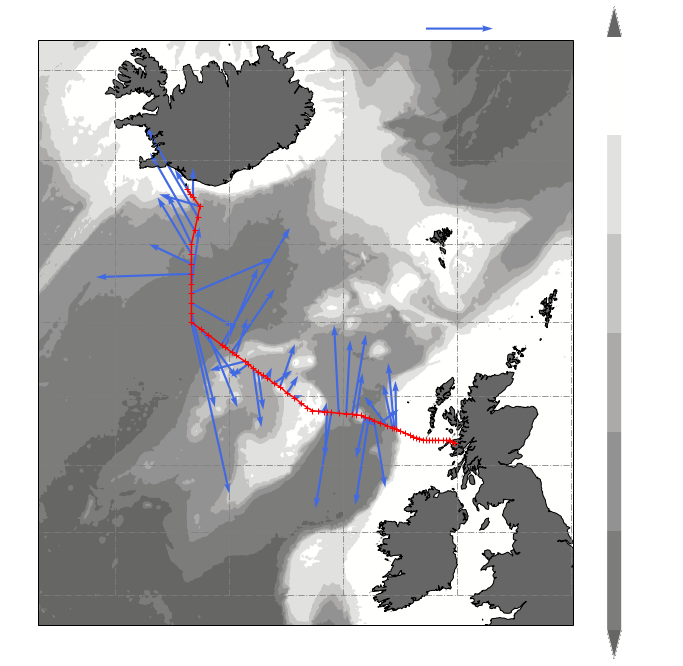

In [19]:
# plot Eastern North Atlantic map with EEL stations
(fig,ax,cplot)=plot_bathy_ENA()    

ax.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree())

# Calculate a transport for each station
lon = np.array(DAClad['LonSta'])
lat = np.array(DAClad['LatSta'])
WD = np.array(DAClad['DepthSta'])
U = np.array(DAClad['mean_U'])*WD/1000 # 1 m2/s -> 1000 m3/s /km -> 0.001 Sv/km 
V = np.array(DAClad['mean_V'])*WD/1000

Qv = ax.quiver(lon, lat, U,  V, transform=ccrs.PlateCarree(),
              scale=0.8,
              color='royalblue',
              width=0.004)
    
qk = ax.quiverkey(Qv,0.85, 1.02, 0.1,'0.1 Sv/km', labelpos='E')

<br><br>
#### Plot regional zoom 

Plot Map for Rockall Trough area with depth average current

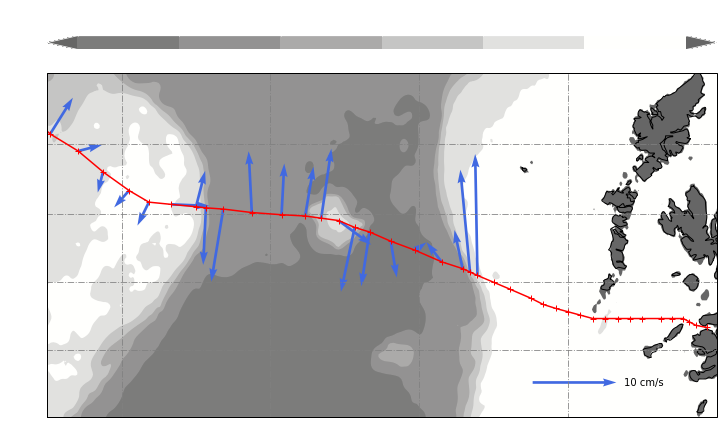

In [20]:
(fig,axRT,cplot)=plot_bathy_ENA(limits=[-15, -6, 56, 58.5],colorbar=False)
plot_gridlines(axRT,np.arange(-20,-2,2),np.arange(55.5,59.5,0.5));

#----------------------------
# EEL stations
axRT.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree());

#----------------------------
# Colorbar
# Add an axes above the main axes.
axRT_divider = make_axes_locatable(axRT)
# Need to import matplotlib's axes class due to the projection used to generate ax2 and ax1
import matplotlib.axes as maxes

caxRT = axRT_divider.append_axes("top", size="4%", pad="7%", axes_class=maxes.Axes)
cb2 = fig.colorbar(cplot, cax=caxRT, orientation="horizontal")
# change tick position to top
caxRT.xaxis.set_ticks_position("top")
caxRT.xaxis.set_label_position("top")
caxRT.set_xlabel('Depth (m)')
#----------------------------
# Colorbar

#------------------------------------------
# Add quiver of depth average current
lon = np.array(DAClad['LonSta'])
lat = np.array(DAClad['LatSta'])
east = np.array(DAClad['mean_U'])
north = np.array(DAClad['mean_V'])
Qv = axRT.quiver(lon, lat, east, north, transform=ccrs.PlateCarree(),
              scale=0.8,
              color='royalblue',#'cornflowerblue',#'dodgerblue',
              width=0.004)

qk = axRT.quiverkey(Qv,0.85, 0.1, 0.1,'10 cm/s', labelpos='E',labelcolor='black')



##### Same map but with the plotted arrows corresponding to the depth average current\*water depth to represent a transport per km

In [21]:
%%capture  

(fig,axRT,cplot)=plot_bathy_ENA(limits=[-15, -6, 56, 58.5],colorbar=False)
plot_gridlines(axRT,np.arange(-20,-2,2),np.arange(55.5,59.5,0.5));

#----------------------------
# EEL stations
axRT.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree());

#----------------------------
# Colorbar

# Add an axes above the main axes.
axRT_divider = make_axes_locatable(axRT)
# Need to import matplotlib's axes class due to the projection used to generate ax2 and ax1
import matplotlib.axes as maxes

caxRT = axRT_divider.append_axes("top", size="4%", pad="7%", axes_class=maxes.Axes)
cb2 = fig.colorbar(cplot, cax=caxRT, orientation="horizontal")
# change tick position to top
caxRT.xaxis.set_ticks_position("top")
caxRT.xaxis.set_label_position("top")
caxRT.set_xlabel('Depth (m)')


Plot quiver

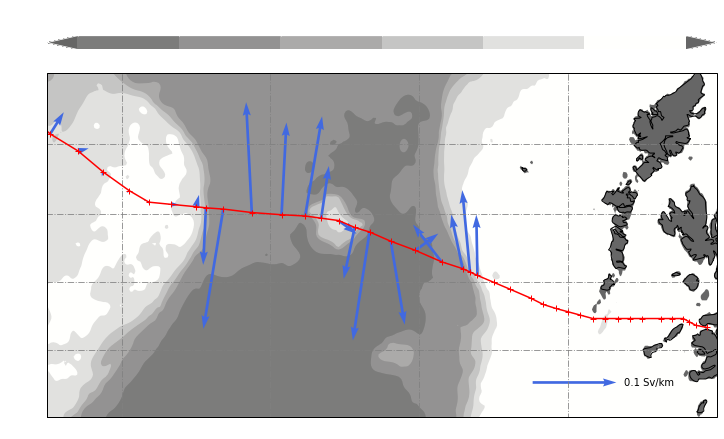

In [22]:

lon = np.array(DAClad['LonSta'])
lat = np.array(DAClad['LatSta'])
WD = np.array(DAClad['DepthSta'])

# Calculate a transport for each station
U = np.array(DAClad['mean_U'])*WD/1000 # 1 m2/s -> 1000 m3/s /km -> 0.001 Sv/km 
V = np.array(DAClad['mean_V'])*WD/1000

Qv = axRT.quiver(lon, lat, U,  V, transform=ccrs.PlateCarree(),
              scale=0.8,
              color='royalblue',
              width=0.004)


qk = axRT.quiverkey(Qv,0.85, 0.1, 0.1,'0.1 Sv/km', labelpos='E',labelcolor='black')

fig

<br><br>
## 3. (TODO Current ellipses of mean current at each EEL station)

Plot map

In [23]:
# %%capture 

# (fig,axRT,cplot)=plot_bathy_ENA(limits=[-15, -6, 56, 58.5],colorbar=False)
# plot_gridlines(axRT,np.arange(-20,-2,2),np.arange(55.5,59.5,0.5));

# #----------------------------
# # EEL stations
# axRT.plot(sdfloc['LonSta'], sdfloc['LatSta'],
#          color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree());

# #----------------------------
# # Colorbar

# # Add an axes above the main axes.
# axRT_divider = make_axes_locatable(axRT)
# # Need to import matplotlib's axes class due to the projection used to generate ax2 and ax1
# import matplotlib.axes as maxes

# caxRT = axRT_divider.append_axes("top", size="4%", pad="7%", axes_class=maxes.Axes)
# cb2 = fig.colorbar(cplot, cax=caxRT, orientation="horizontal")
# # change tick position to top
# caxRT.xaxis.set_ticks_position("top")
# caxRT.xaxis.set_label_position("top")
# caxRT.set_xlabel('Depth (m)')


Plot ellipse

In [24]:
# # Calculate a transport for each station
# lon = np.array(DAClad['LonSta'])
# lat = np.array(DAClad['LatSta'])
# WD = np.array(DAClad['DepthSta'])
# U = np.array(DAClad['mean_U'])*WD/1000 # 1 m2/s -> 1000 m3/s /km -> 0.001 Sv/km 
# V = np.array(DAClad['mean_V'])*WD/1000

# Qv = axRT.quiver(lon, lat, U,  V, transform=ccrs.PlateCarree(),
#               scale=0.8,
#               color='royalblue',
#               width=0.004)


# qk = axRT.quiverkey(Qv,0.85, 0.1, 0.1,'10 cm/s', labelpos='E',labelcolor='black')
# fig

### TODO: Produce other version of the figure with mean current ellipses at different depths (eg 100m, 800m, 2500m)
### Perhaps with some representation of data coverage (eg dot size to indicate number of occupations of each station)?